<h1 align="center">Procesamiento de muestra de datos del Covid19 en Colombia</h1>
<div align="right">David A. Miranda, PhD<br>2021</div>

En este Jypyter Notebook se analiza una muestra de datos de Covid19 extraída de [datos.org.co](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data).

## 1. Cargar Librerías

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from scipy import stats
from datetime import datetime

## 2. Cargar datos
### 2.1. Carga datos locales, si tienes clonado el repositorio

In [2]:
data = pd.DataFrame([])
try:
    data = pd.read_csv('../data/20210411_Covid19_Santander.cvs.zip', low_memory=False)
except:
    print('Error! There are no local data; try with online data.')

### 2.2. Carga datos desde la nube

In [3]:
try:
    data = pd.read_csv('https://github.com/davidalejandromiranda/StatisticalPhysics/blob/main/data/20210411_Covid19_Santander.cvs?raw=true', low_memory=False, error_bad_lines=False)
except:
    print('Error! It was not possible to get online data; please, check your Internet connection.')

## 3. Descripción de los datos
### 3.1. El método *describe()* de pandas

In [4]:
data.describe()

,Unnamed: 0,ID de caso,Código DIVIPOLA departamento,Código DIVIPOLA municipio,Edad,Unidad de medida de edad,Código ISO del país,Pertenencia étnica
count,9.585400e+04,9.585400e+04,95854.0,95854.000000,95854.000000,95854.000000,63.000000,95457.000000
mean,1.243086e+06,1.243127e+06,68.0,68181.921631,41.757777,1.003641,598.111111,5.983322
std,6.261435e+05,6.261436e+05,0.0,222.995336,18.395689,0.066644,291.751336,0.234685
min,5.900000e+01,6.000000e+01,68.0,68001.000000,1.000000,1.000000,4.000000,1.000000
25%,7.036588e+05,7.036998e+05,68.0,68001.000000,28.000000,1.000000,340.000000,6.000000
50%,1.196687e+06,1.196728e+06,68.0,68081.000000,39.000000,1.000000,724.000000,6.000000
75%,1.762688e+06,1.762728e+06,68.0,68276.000000,54.000000,1.000000,840.000000,6.000000
max,2.510033e+06,2.510074e+06,68.0,68895.000000,107.000000,3.000000,862.000000,6.000000


### 3.2. Columnas en la tabla de datos

In [5]:
data.columns

Index(['Unnamed: 0', 'fecha reporte web', 'ID de caso',
       'Fecha de notificación', 'Código DIVIPOLA departamento',
       'Nombre departamento', 'Código DIVIPOLA municipio', 'Nombre municipio',
       'Edad', 'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
       'Ubicación del caso', 'Estado', 'Código ISO del país',
       'Nombre del país', 'Recuperado', 'Fecha de inicio de síntomas',
       'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación',
       'Tipo de recuperación', 'Pertenencia étnica',
       'Nombre del grupo étnico'],
      dtype='object')

### 3.3. Valores unicos de una columna

In [6]:
data['Nombre municipio'].unique()

array(['FLORIDABLANCA', 'BUCARAMANGA', 'BARRANCABERMEJA', 'CIMITARRA',
       'CONCEPCION', 'CURITI', 'PIEDECUESTA', 'VILLANUEVA', 'SOCORRO',
       'GIRON', 'GUAPOTA', 'BARBOSA', 'LEBRIJA', 'LA BELLEZA',
       'SAN VICENTE DE CHUCURI', 'SUAITA', 'MALAGA', 'SABANA DE TORRES',
       'PUERTO WILCHES', 'BARICHARA', 'PUERTO PARRA', 'SAN GIL',
       'RIONEGRO', 'EL PEÑON', 'LA PAZ', 'OIBA', 'LOS SANTOS', 'GALAN',
       'MOGOTES', 'SANTA HELENA DEL OPON', 'HATO', 'ONZAGA', 'LANDAZURI',
       'CEPITA', 'VALLE DE SAN JOSE', 'SAN JOAQUIN', 'AGUADA',
       'CALIFORNIA', 'SAN ANDRES', 'MATANZA', 'SAN JOSE DE MIRANDA',
       'ARATOCA', 'EL PLAYON', 'VELEZ', 'BOLIVAR', 'CARCASI', 'ZAPATOCA',
       'EL CARMEN DE CHUCURI', 'PARAMO', 'SAN BENITO', 'CONFINES',
       'EL GUACAMAYO', 'PINCHOTE', 'COROMORO', 'GUAVATA', 'TONA',
       'BETULIA', 'VETAS', 'CHIPATA', 'GUACA', 'SUCRE', 'MOLAGAVITA',
       'CAPITANEJO', 'CONTRATACION', 'CHARALA', 'CHIMA', 'CERRITO',
       'FLORIAN', 'ENCINO', 'SANTA

### 3.4. Obtención de todas las filas para un valor de una columna

In [7]:
data_buc = data.loc[data['Nombre municipio'] == 'BUCARAMANGA']

In [8]:
mask = data['Nombre municipio'] == 'BUCARAMANGA'
data_buc = data.loc[mask]

In [9]:
data_buc.describe()

,Unnamed: 0,ID de caso,Código DIVIPOLA departamento,Código DIVIPOLA municipio,Edad,Unidad de medida de edad,Código ISO del país,Pertenencia étnica
count,4.100800e+04,4.100800e+04,41008.0,41008.0,41008.000000,41008.000000,34.000000,40810.000000
mean,1.244734e+06,1.244775e+06,68.0,68001.0,41.838251,1.004219,546.941176,5.986498
std,6.225281e+05,6.225281e+05,0.0,0.0,18.517574,0.071608,290.278335,0.203112
min,8.800000e+01,8.900000e+01,68.0,68001.0,1.000000,1.000000,4.000000,1.000000
25%,6.976522e+05,6.976932e+05,68.0,68001.0,28.000000,1.000000,277.500000,6.000000
50%,1.200904e+06,1.200945e+06,68.0,68001.0,39.000000,1.000000,591.000000,6.000000
75%,1.764426e+06,1.764467e+06,68.0,68001.0,55.000000,1.000000,840.000000,6.000000
max,2.510020e+06,2.510061e+06,68.0,68001.0,107.000000,3.000000,862.000000,6.000000


## 4. Análisis de la columna *Recuperado* para datos Covid19
### 4.1. Limpieza básica de datos: unificar nombre de columnas

In [10]:
data['Recuperado'].unique()

array(['Recuperado', 'Fallecido', nan, 'fallecido', 'Activo'],
      dtype=object)

In [11]:
data.loc[data['Recuperado'] == 'fallecido', 'Recuperado'] = 'Fallecido'

In [12]:
status_labels = data['Recuperado'].unique()
status_labels

array(['Recuperado', 'Fallecido', nan, 'Activo'], dtype=object)

### 4.2. Gráfica de cuenta de valores de la columna

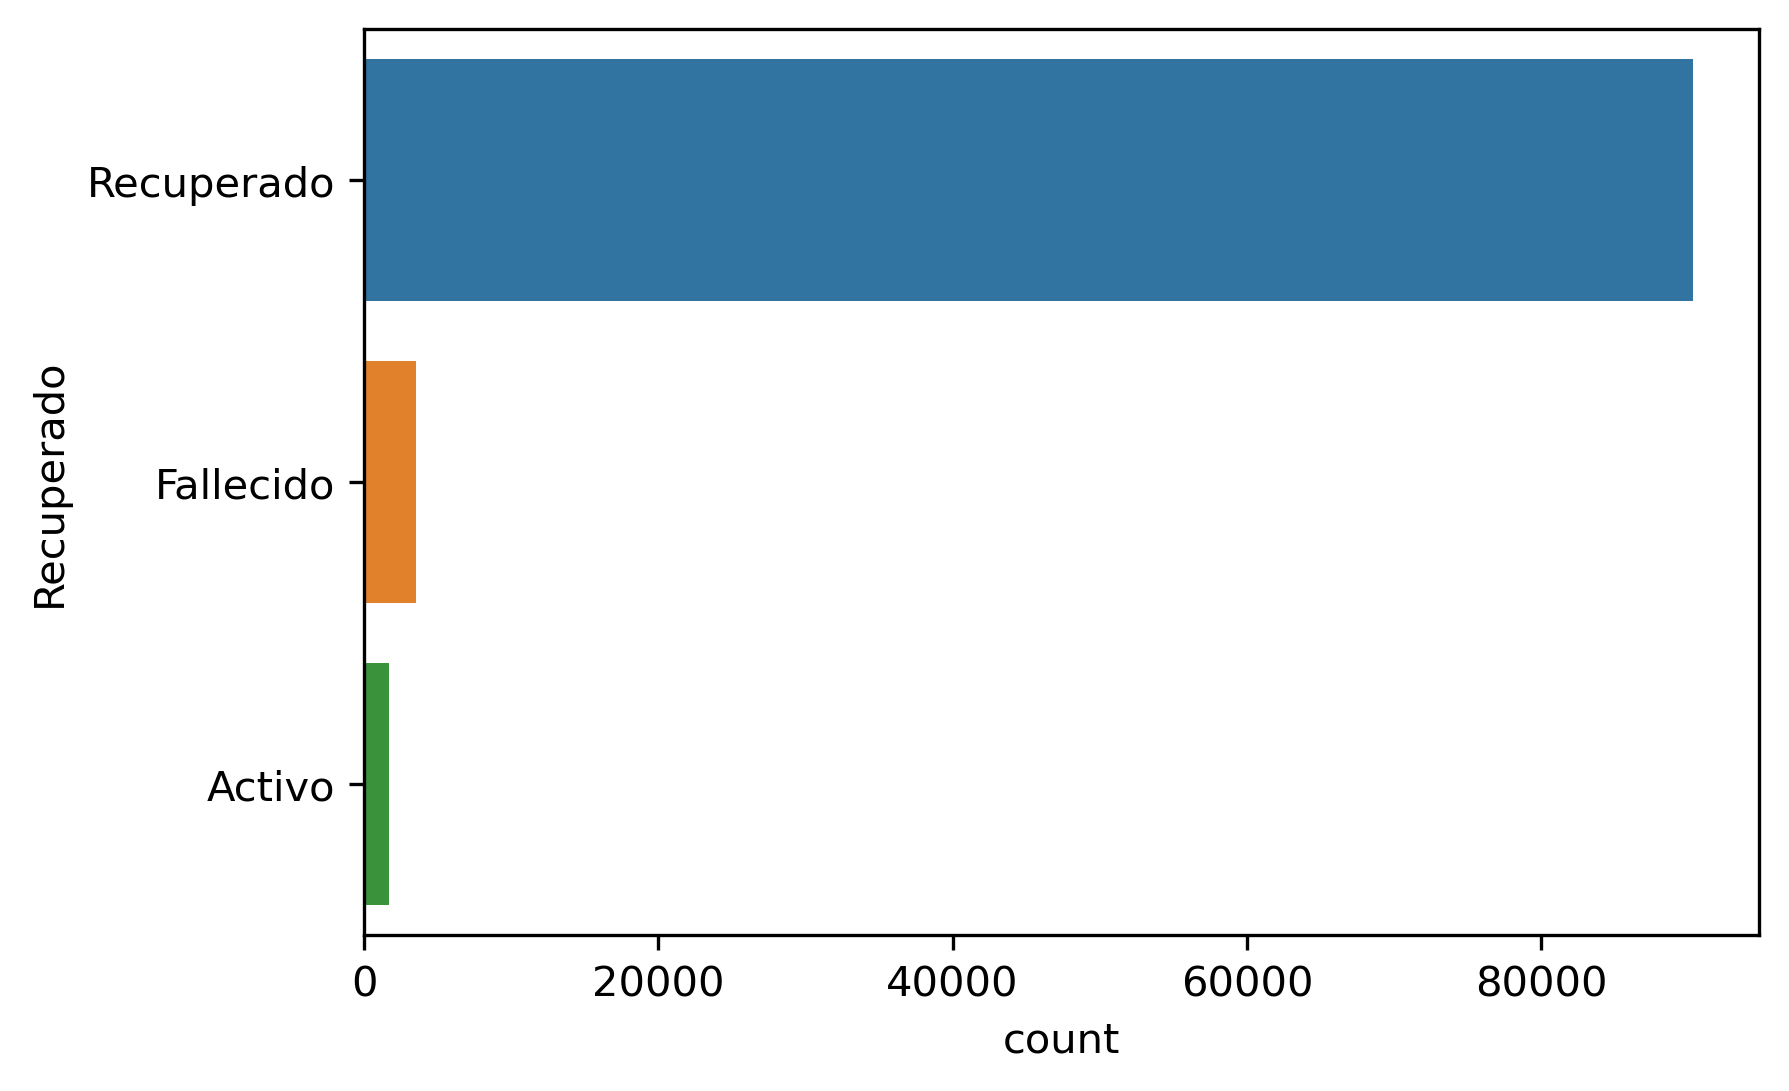

In [13]:
plt.figure(dpi=300)
ax = sns.countplot(y='Recuperado', ax=plt.gca(), data=data)

### 4.3. Tabla con cuenta de valores de la columna

In [14]:
data.groupby('Recuperado').describe()

Unnamed: 0                                                      \
                count          mean            std        min         25%   
Recuperado                                                                  
Activo         1654.0  2.204311e+06  351394.902802  1409312.0  1925019.25   
Fallecido      3530.0  1.124342e+06  639912.916223     1485.0   556829.25   
Recuperado    90328.0  1.231246e+06  615349.979617       59.0   703744.50   

                                             ID de caso                ...  \
                  50%         75%        max      count          mean  ...   
Recuperado                                                             ...   
Activo      2411785.0  2485591.75  2510033.0     1654.0  2.204352e+06  ...   
Fallecido    995634.5  1667585.50  2496245.0     3530.0  1.124383e+06  ...   
Recuperado  1185112.0  1738887.50  2496239.0    90328.0  1.231287e+06  ...   

           Código ISO del país        Pertenencia étnica                      \
                           75%    max              count      mean       std   
Recuperado                                                                     
Activo                   840.0  840.0             1287.0  5.994561  0.073577   
Fallecido                862.0  862.0             3528.0  5.986678  0.186269   
Recuperado               840.0  862.0            90300.0  5.982990  0.238255   

                                     
            min  25%  50%  75%  max  
Recuperado                           
Activo      5.0  6.0  6.0  6.0  6.0  
Fallecido   1.0  6.0  6.0  6.0  6.0  
Recuperado  1.0  6.0  6.0  6.0  6.0  

[3 rows x 64 columns]

### 4.4. Procesamiento de cuentas por agrupamiento

In [15]:
recuperado_data = data.groupby('Recuperado')


In [16]:
num_Activo = len(recuperado_data.groups['Activo'])
num_Fallecido = len(recuperado_data.groups['Fallecido'])
num_Recuperado = len(recuperado_data.groups['Recuperado'])
num_Total = num_Activo + num_Fallecido + num_Recuperado

#### 4.4.1. Organización de datos procesados en una tabla de Pandas

In [17]:
perc_recuperado = pd.DataFrame({
    'Estado':[
        'Activos',
        'Recuperados',
        'Fallecidos'],
    '%':[ 
        100*num_Activo/num_Total,
        100*num_Recuperado/num_Total,
        100*num_Fallecido/num_Total,
        ],
})
perc_recuperado

,Estado,%
0,Activos,1.731720
1,Recuperados,94.572410
2,Fallecidos,3.695871


#### 4.4.2. Redondeo de datos

In [18]:
perc_recuperado['%'] = perc_recuperado.apply(lambda row: np.round(row['%'], 1), axis=1)
perc_recuperado

,Estado,%
0,Activos,1.7
1,Recuperados,94.6
2,Fallecidos,3.7


## 5. Análisis de la columna *Edad* para datos Covid19
### 5.1. Limpieza de datos: eliminación de datos inválidos

In [19]:
for e in data['Edad']:
    try:
        float(e)
    except:
        print(e)

In [20]:
data['Edad'] = data.apply(lambda row: np.NaN if type(row['Edad']) == type('String') else row['Edad'], axis=1)

In [21]:
for e in data['Edad']:
    try:
        float(e)
    except:
        print(e)

### 5.2. Diagrama de violín
#### 5.2.1. Todos los datos

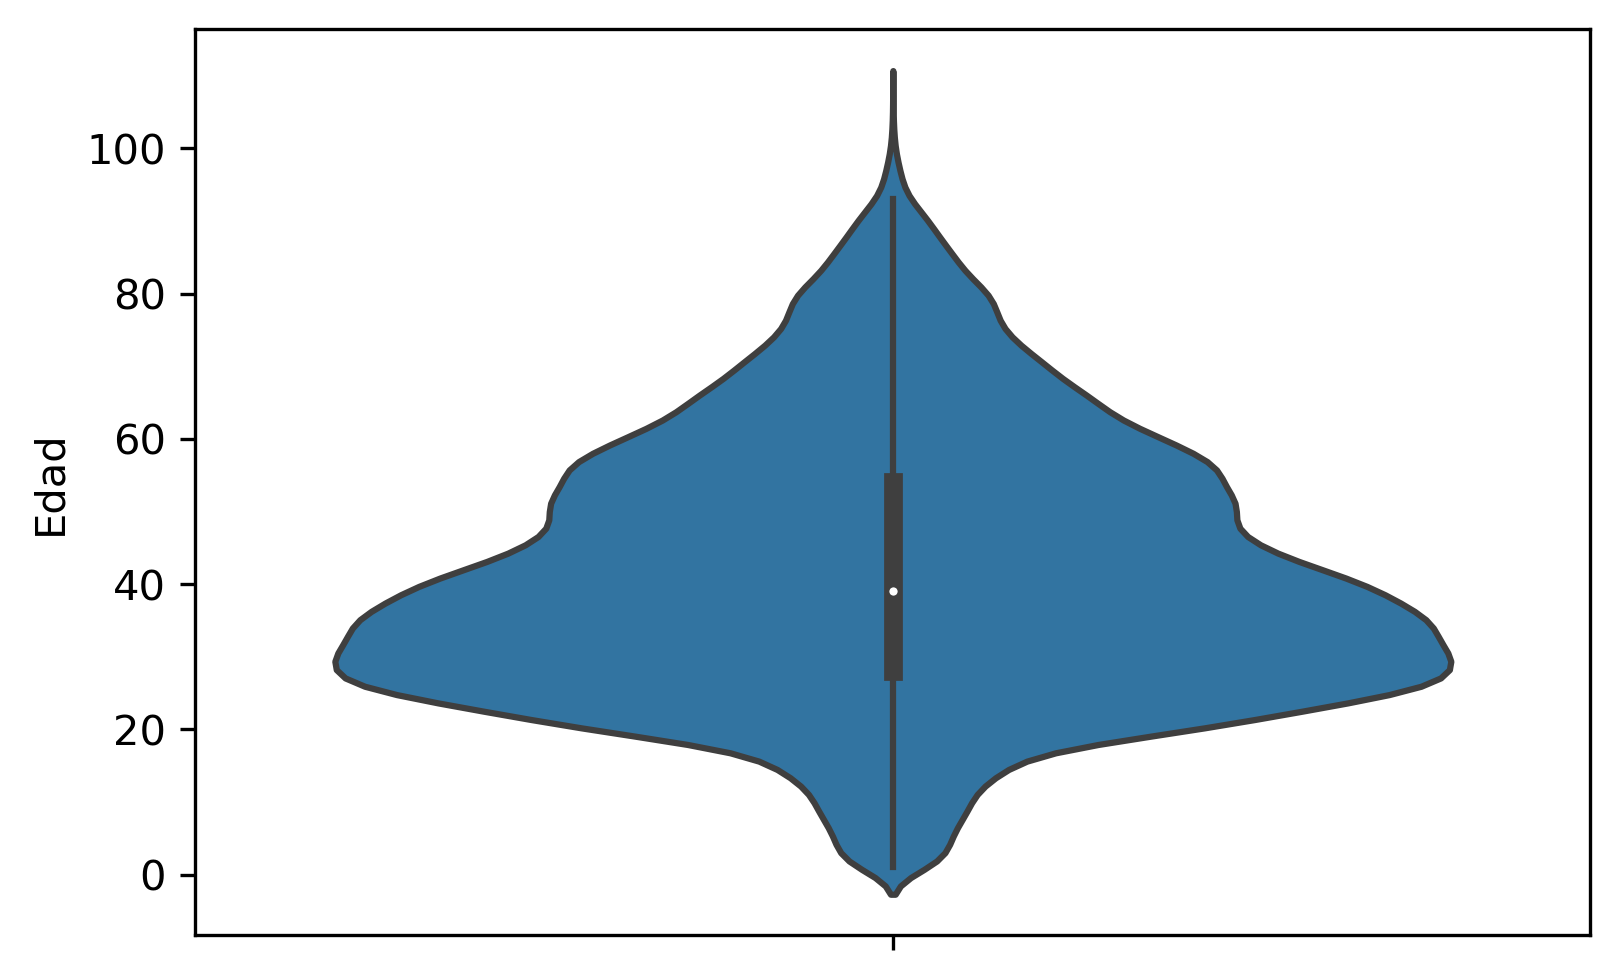

In [22]:
plt.figure(dpi=300)
_ = sns.violinplot(y='Edad', data=data, ax=plt.gca())

#### 5.2.2. Por agrupamientos

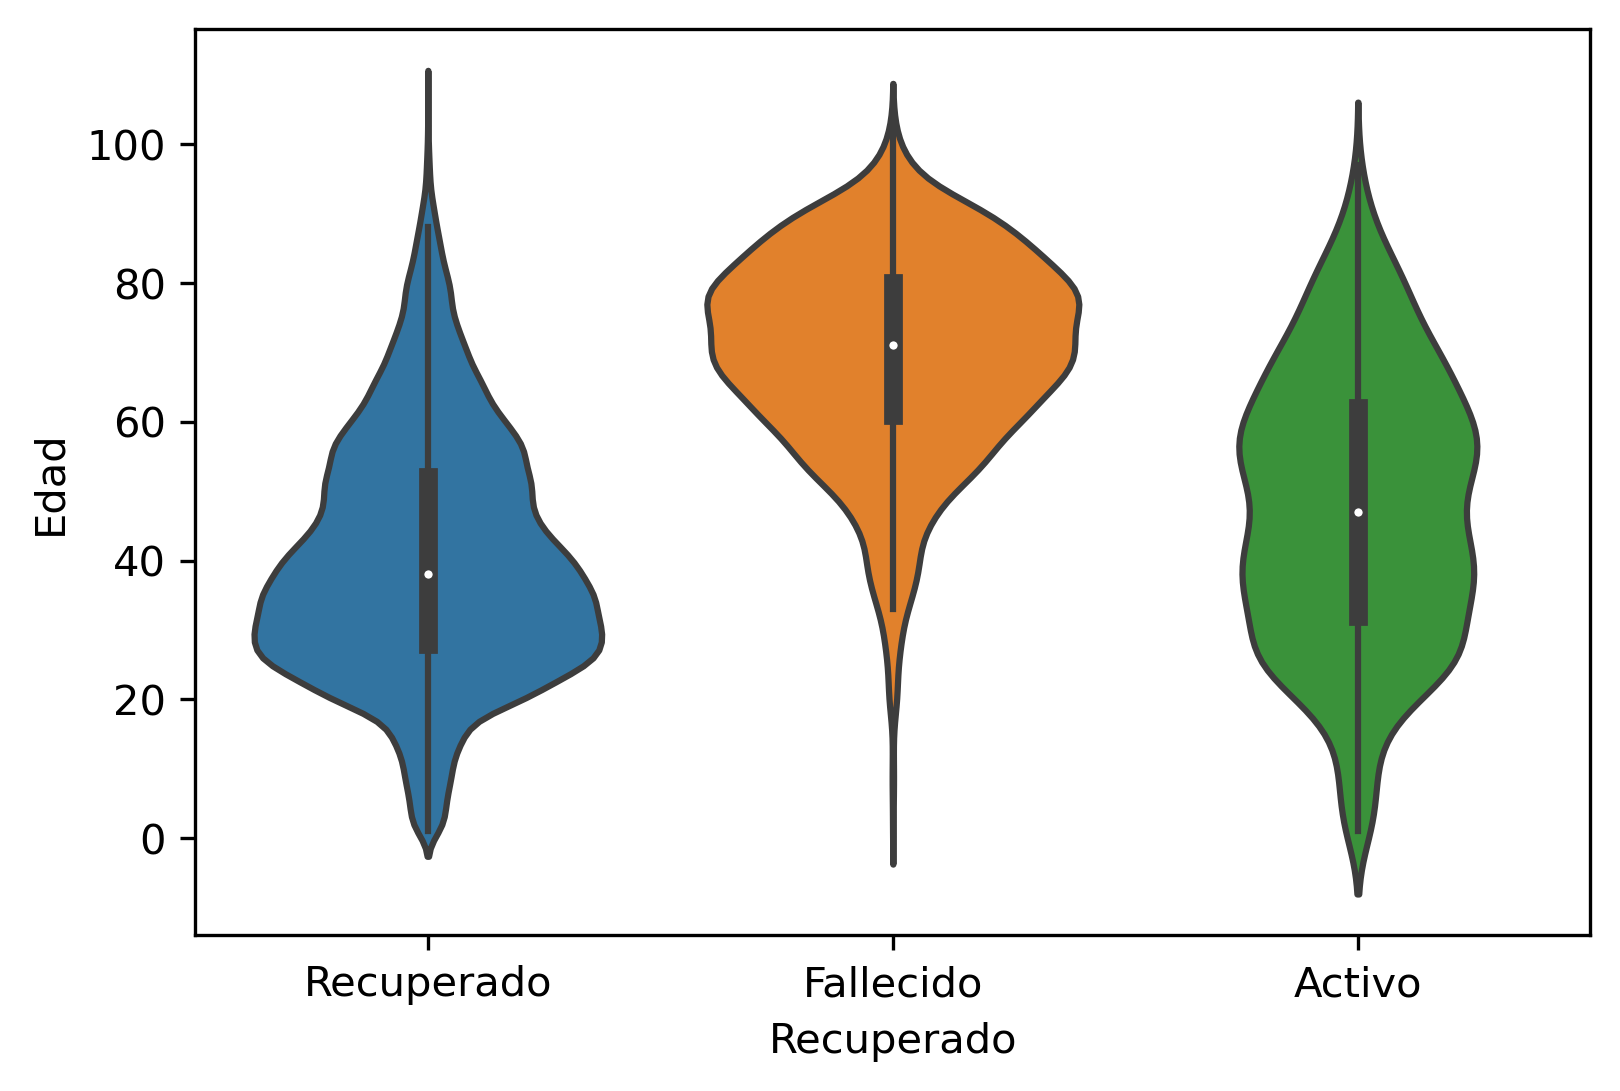

In [23]:
plt.figure(dpi=300)
_ = sns.violinplot(x='Recuperado', y='Edad', data=data, ax=plt.gca())

### 5.3. Gráficos Boxplot
#### 5.2.1. Todos los datos

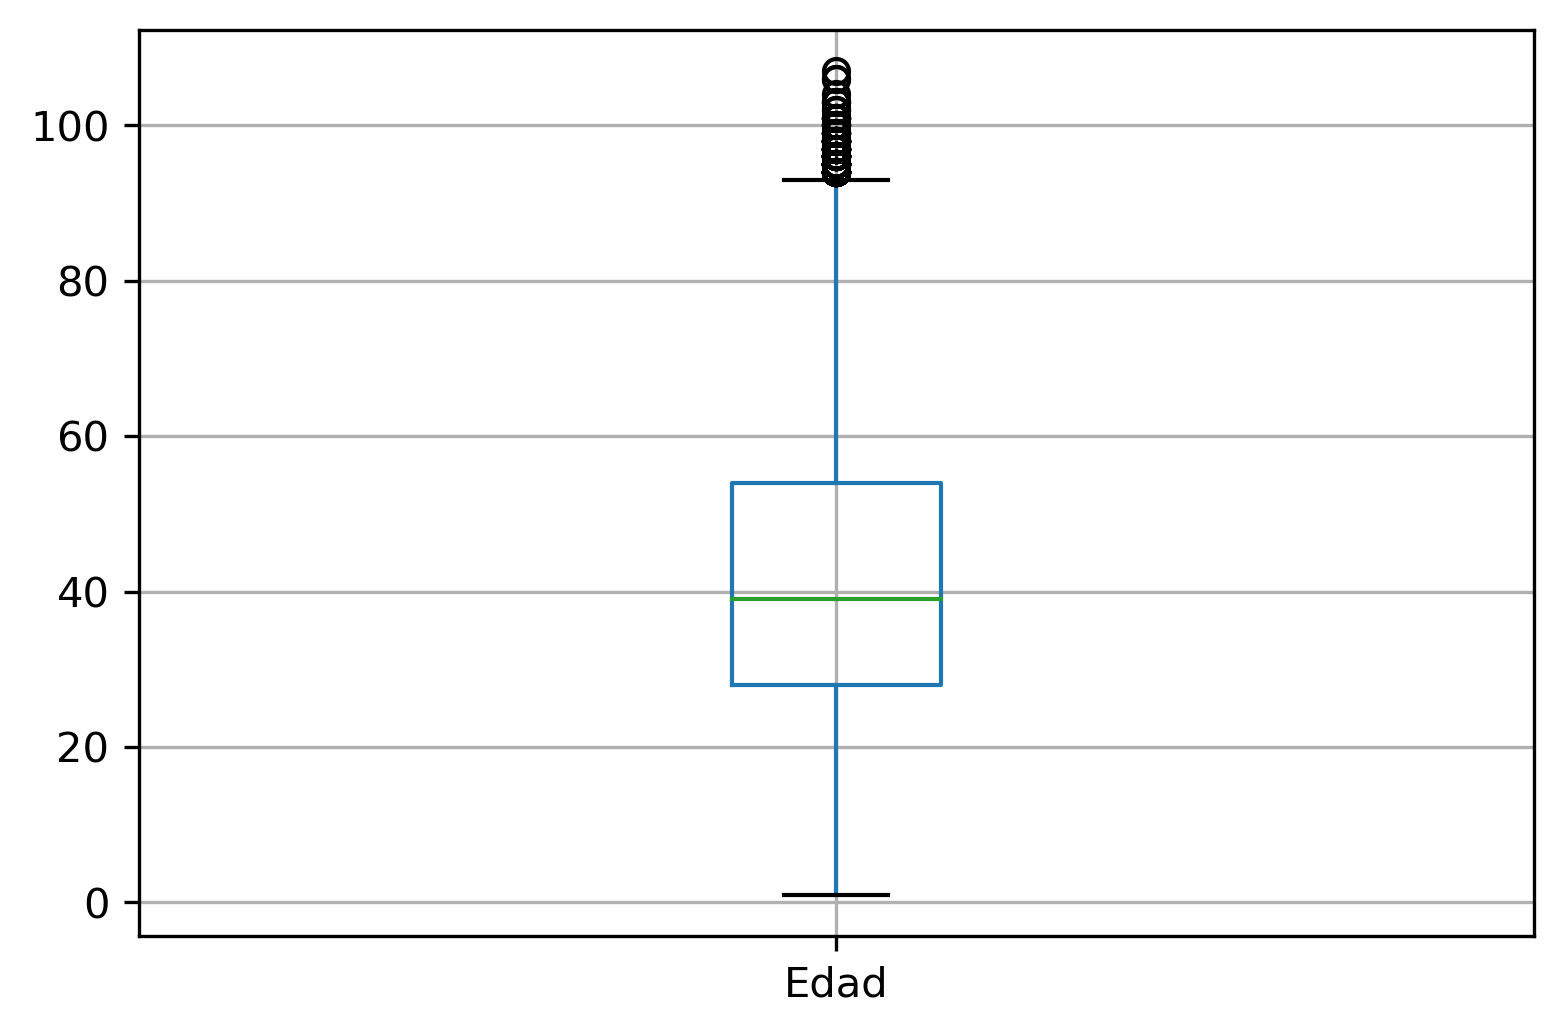

In [24]:
plt.figure(dpi=300)
_ = data.boxplot(column='Edad', ax=plt.gca())

#### 5.3.2. Por agrupamientos

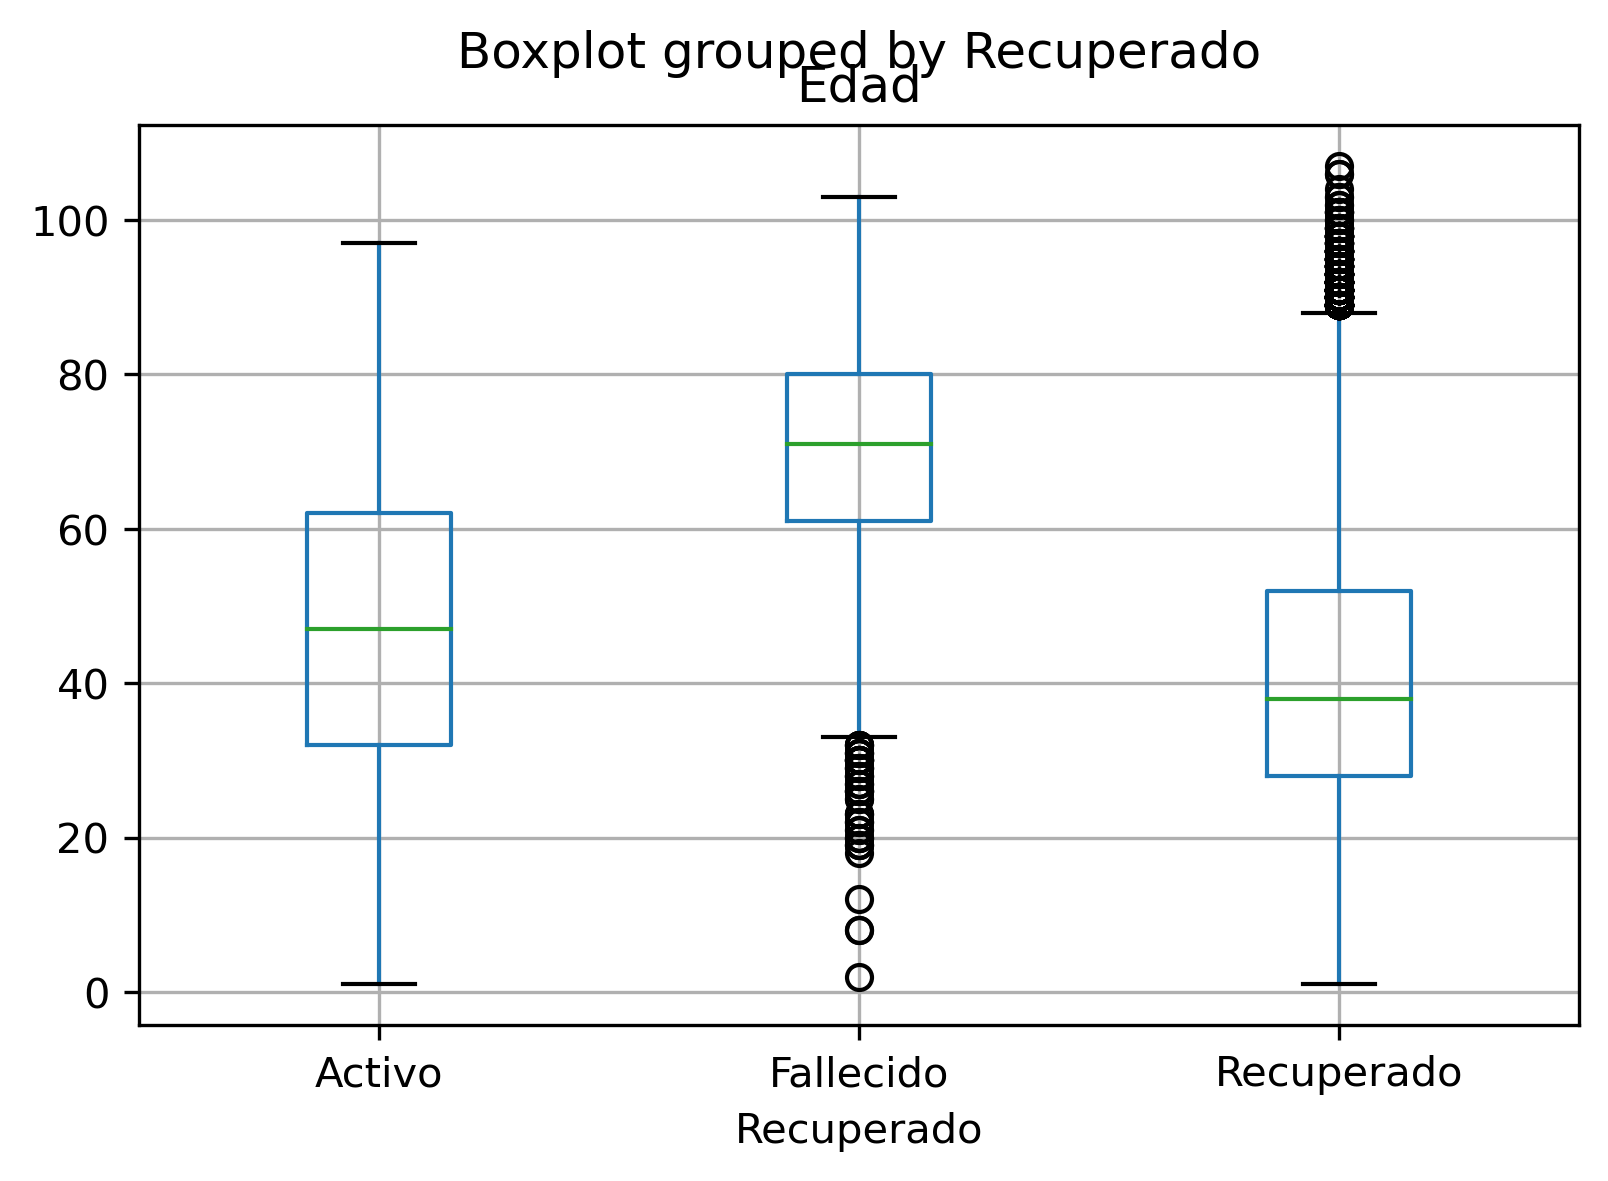

In [25]:
plt.figure(dpi=300)
_ = data.boxplot(column='Edad', by='Recuperado', ax=plt.gca())

## 6. Pruebas de normalidad
Hay diferentes [pruebas de normalidad](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/), en este Jupyter Notebook se aplican tres de ellas.
### 6.1. Limpieza de datos: eliminación de datos no finitos

In [26]:
mask = np.isfinite(data['Edad'])
data = data.loc[mask]

### 6.2. Prueba de [Kolmogorov–Smirnov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)
Esta es una prueba no parámetrica para determinar si una cierta muestra sigue una determinada distribución de probabilidad.  Esta prueba cuantifica la distancia entre la función de distribución empírica de una muestra y la función de distribución acumulativa de la distribución de referencia.

La hipótesis nula es que los datos analizados siguen la distribución de referencia. Si $p-value \geq 0.05$, se acepta la hipótesis nula, de lo contrario, se rechaza. 
#### 6.2.1. Para todos los datos

In [27]:
ks = stats.kstest(data['Edad'],'norm')
print('statiscic: %0.2f, p-value=%0.5g\n' % (ks.statistic, ks.pvalue))

statiscic: 0.99, p-value=0



#### 6.2.1. Para cada conjunto agrupados por *Recuperado*

In [28]:
recuperado_data = data.groupby('Recuperado')
ks_dict = {'status':[], 'statistic':[], 'p':[]} 
for group, this_data in recuperado_data:
    ks = stats.kstest(data['Edad'],'norm')
    ks_dict['status'].append(group)
    ks_dict['statistic'].append(ks.statistic)
    ks_dict['p'].append(ks.pvalue)
ks_df = pd.DataFrame(ks_dict)
ks_df

,status,statistic,p
0,Activo,0.993757,0.0
1,Fallecido,0.993757,0.0
2,Recuperado,0.993757,0.0


### 6.2. Prueba [Anderson-Darling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)
Esta prueba estadística permite deterimar si una muestra sigue una cierta distribución estadística de referencia.  

La hipótesis nula para esta prueba es que los datos corresponden con la distribución de referencia.

Si el estadístico es mayor que los valores críticos para los niveles de significancia, entonces, se dice que la hipótesis nula es rechazada.

#### 6.3.1. Para todos los datos

In [29]:
ad = stats.anderson(data['Edad'], dist='norm')
ad

AndersonResult(statistic=665.6772232188669, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### 6.3.1. Para cada conjunto agrupados por *Recuperado*

In [30]:
recuperado_data = data.groupby('Recuperado')
ad_dict = {'status':[], 'statistic':[]} 
for group, this_data in recuperado_data:
    ad = stats.anderson(data['Edad'], dist='norm')
    ad_dict['status'].append(group)
    ad_dict['statistic'].append(ad.statistic)
    idx = 0
    for c in ad.critical_values:
        idx += 1
        key = 'Critical Value %d' % idx
        if not key in ad_dict.keys():
            len_status = len(ad_dict['status'])
            ad_dict[key] = [] if len_status == 1 else len_status*[np.NaN]
        ad_dict[key].append(c)
    idx = 0
    for s in ad.significance_level:
        idx += 1
        key = 'Significance Level %d' % idx
        if not key in ad_dict.keys():
            len_status = len(ad_dict['status'])
            ad_dict[key] = [] if len_status == 1 else len_status*[np.NaN]
        ad_dict[key].append(s)

ad_df = pd.DataFrame(ad_dict)
ad_df

,status,statistic,Critical Value 1,Critical Value 2,Critical Value 3,Critical Value 4,Critical Value 5,Significance Level 1,Significance Level 2,Significance Level 3,Significance Level 4,Significance Level 5
0,Activo,665.677223,0.576,0.656,0.787,0.918,1.092,15.0,10.0,5.0,2.5,1.0
1,Fallecido,665.677223,0.576,0.656,0.787,0.918,1.092,15.0,10.0,5.0,2.5,1.0
2,Recuperado,665.677223,0.576,0.656,0.787,0.918,1.092,15.0,10.0,5.0,2.5,1.0


### 6.3. Prueba de [Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Esta prueba estadística permite determinar si los datos siguen una distribución normal.

La hipótesis nula es que los datos siguen la distribución normal.  Si $p-value \geq 0.05$, se acepta la hipótesis nula, de lo contrario, se rechaza.
#### 6.3.1. Para todos los datos

In [31]:
statistic, p = stats.shapiro(data['Edad'])
print('statiscic: %0.2f, p-value=%0.5g\n' % (statistic, p))

statiscic: 0.98, p-value=0

/Users/david1/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### 6.3.1. Para cada conjunto agrupados por *Recuperado*

In [32]:
recuperado_data = data.groupby('Recuperado')
sw_dict = {'status':[], 'statistic':[], 'p':[]} 
for group, this_data in recuperado_data:
    statistic, p = stats.shapiro(data['Edad'])
    sw_dict['status'].append(group)
    sw_dict['statistic'].append(statistic)
    sw_dict['p'].append(p)
sw_df = pd.DataFrame(sw_dict)
sw_df

,status,statistic,p
0,Activo,0.979739,0.0
1,Fallecido,0.979739,0.0
2,Recuperado,0.979739,0.0


## 7. Análisis básico de evolución temporal

In [33]:
time_labels = ['fecha reporte web', 'Fecha de notificación', 'Fecha de inicio de síntomas','Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación']

### 7.1. Limpieza de datos: conversión de formato y remoción de datos inválidos

In [34]:
time_label='Fecha de diagnóstico'
date_time_str = data[time_label]
for d in date_time_str:
    try: # Verifica si los datos tienen el formato 14/04/2020 00:00:00
        datetime.strptime(d, '%d/%m/%Y %H:%M:%S')
    except: # Si Python reportó error, se ejecuta la siguiente línea
        print(d)
        break

nan


In [35]:
def to_datetime(row, time_label='Fecha de diagnóstico'):
    d = row[time_label]
    this_data = None
    is_valid = []
    try: # Verifica si los datos tienen el formato 14/04/20 00:00:00
        is_valid.append(True)
        this_data = datetime.strptime(d, '%d/%m/%y %H:%M:%S')
    except:
        is_valid.append(False)
    try: # Verifica si los datos tienen el formato 14/04/2020 00:00:00
        is_valid.append(True)
        this_data = datetime.strptime(d, '%d/%m/%Y %H:%M:%S')
    except:
        is_valid.append(False)
    if not True in is_valid: # Devuelve NaN si no se encontraron datos en los formatos anteriores
        return np.NaN
    return this_data

In [36]:
data[time_label] = data.apply(to_datetime, axis= 1)
mask = ~data[time_label].isna()
data = data.loc[mask]

### 7.2. Línea temporal

In [37]:
t0 = min(data[time_label])
t_serie = data[time_label] - t0
data['t [días]'] = [d.days for d in t_serie]

<ipython-input-37-2f03b128d8cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t [días]'] = [d.days for d in t_serie]


### 7.3. Submuestreo y gráfica de la columna *Edad* en función del tiempo
#### 7.3.1. Submuestreo para graficar solo N muestras

In [38]:
N = 500
data_len = len(data)
k = np.arange(0, data_len, int(data_len/N))

#### 7.3.2. Gráfica para todas las edades

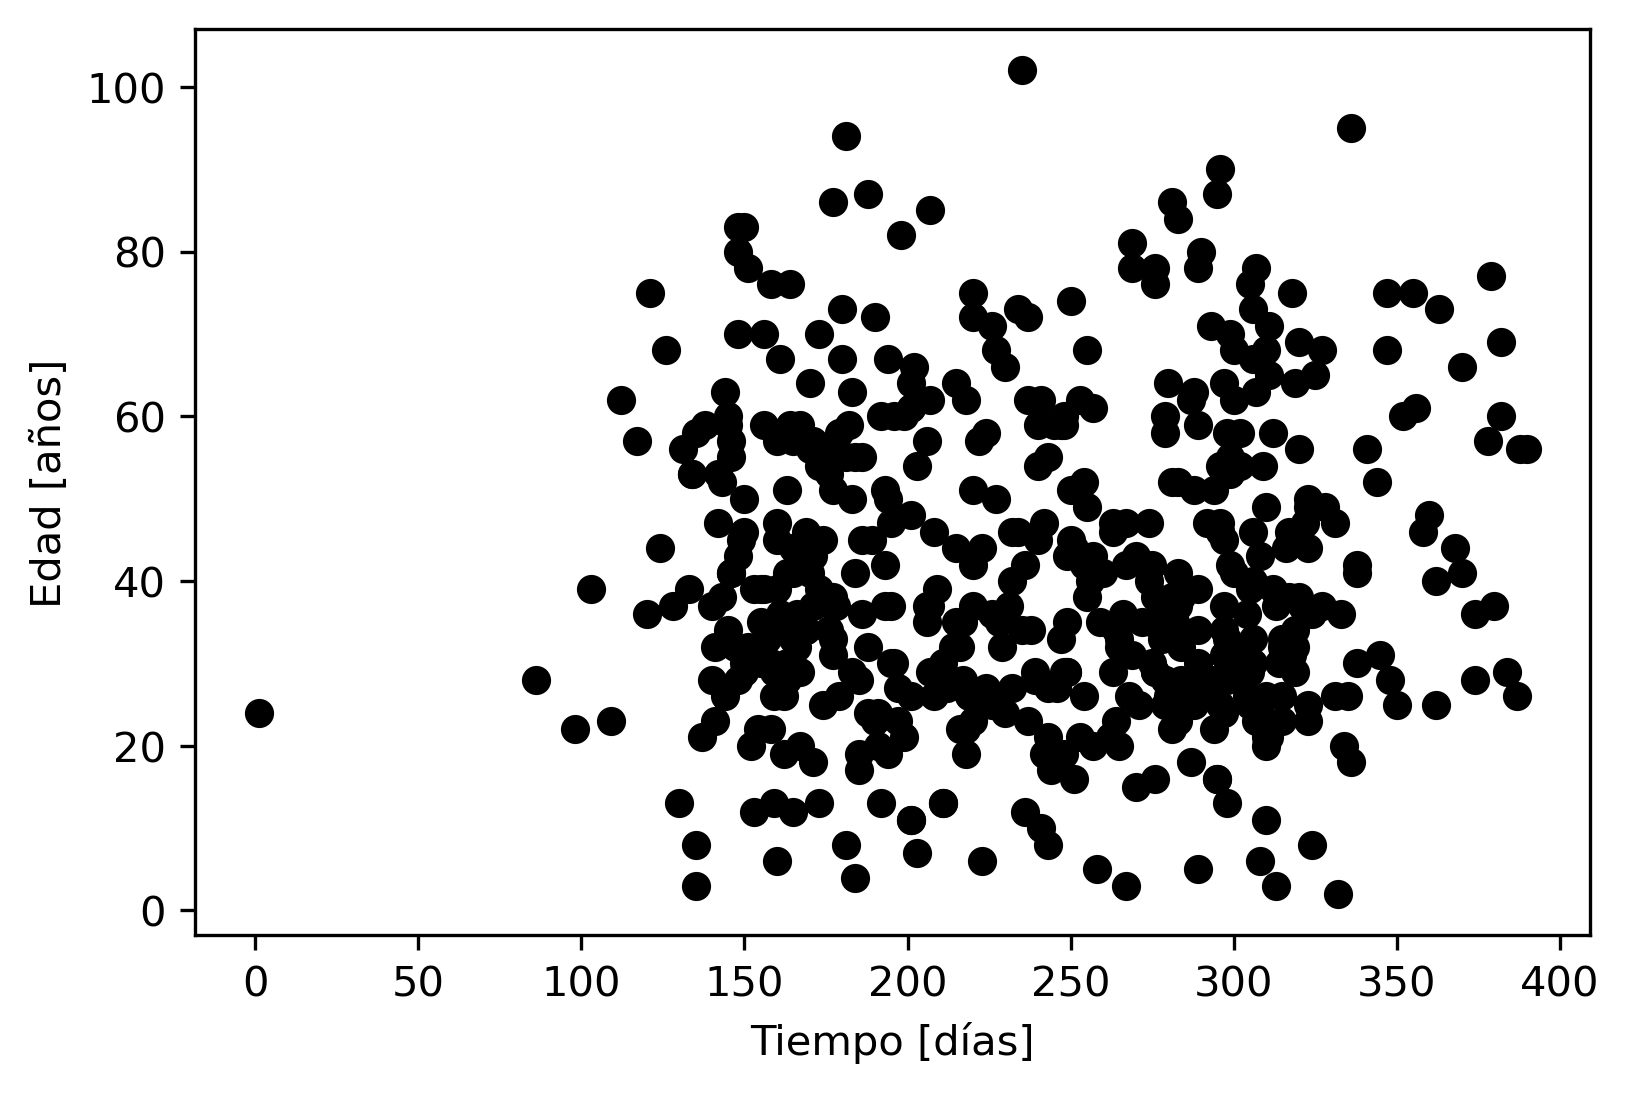

In [39]:
plt.figure(dpi=300)
plt.plot(data.iloc[k]['t [días]'], data.iloc[k]['Edad'], 'ko')
plt.xlabel('Tiempo [días]')
_ = plt.ylabel('Edad [años]')

#### 7.3.2. Gráfica de edades por agrupamiento por *Recuperado*

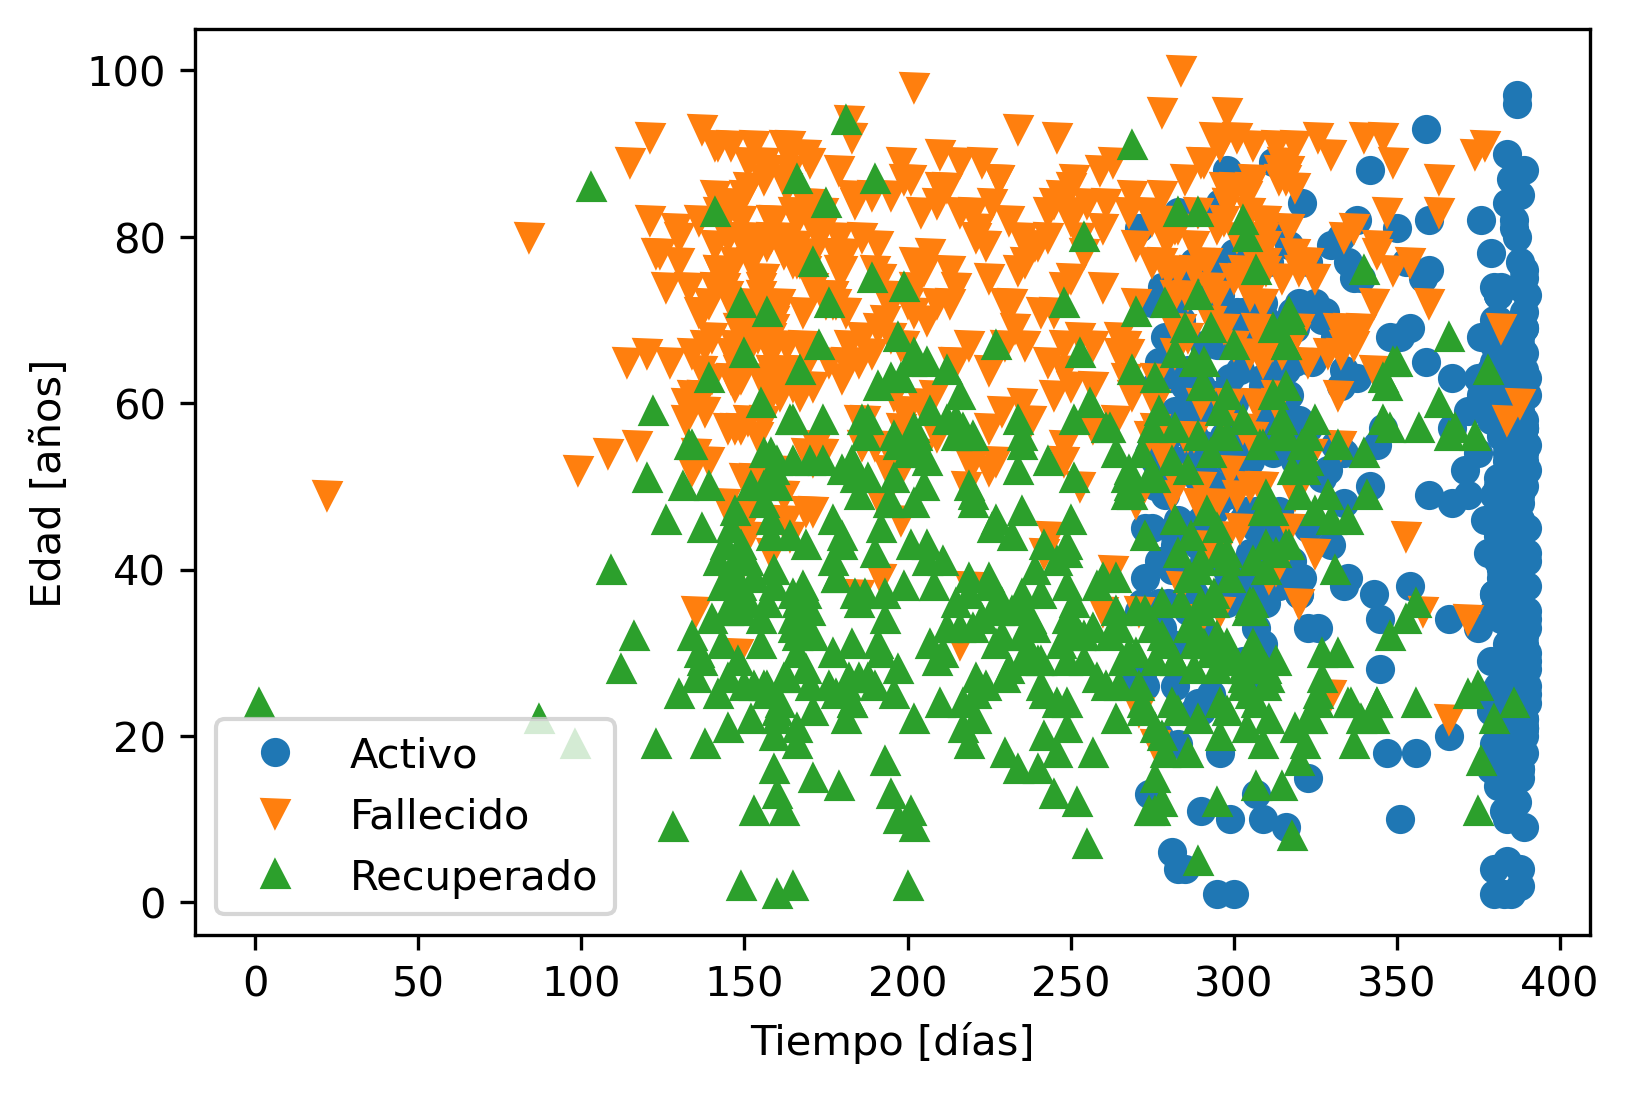

In [40]:
recuperado_data = data.groupby('Recuperado')
plt.figure(dpi=300)
marks = 'ov^>'
idx = -1
for group, this_data in recuperado_data:
    data_len = len(this_data)
    k = np.arange(0, data_len, int(data_len/N))
    idx += 1
    plt.plot(this_data.iloc[k]['t [días]'], this_data.iloc[k]['Edad'], marks[idx], label=group)
plt.xlabel('Tiempo [días]')
plt.ylabel('Edad [años]')
_ = plt.legend()

### 7.4. Medias para cada 30 días
#### 7.4.1. Método para obtener las medias mensuales para la *Edad*

In [41]:
def get_means(df):
    t2_array = np.arange(1, int(max(df['t [días]']))+30, 30)
    t1_array = t2_array - 1
    t = []
    mean = []
    for t1, t2 in zip(t1_array, t2_array):
        mask = (df['t [días]'] >= t1) & (df['t [días]'] < t2)
        t.append(t1/30)
        mean.append(np.mean(df.loc[mask, 'Edad'].dropna()))
    return t, mean

#### 7.4.2. Método para obtener el número de casos mensuales

In [42]:
def get_counts(df):
    t2_array = np.arange(1, int(max(df['t [días]']))+30, 30)
    t1_array = t2_array - 1
    t = []
    counts = []
    for t1, t2 in zip(t1_array, t2_array):
        mask = (df['t [días]'] >= t1) & (df['t [días]'] < t2)
        t.append(t1/30)
        counts.append(np.count_nonzero(mask.dropna()))
    return t, counts

#### 7.4.2. Gráfica de media de edades por agrupamiento por *Recuperado*

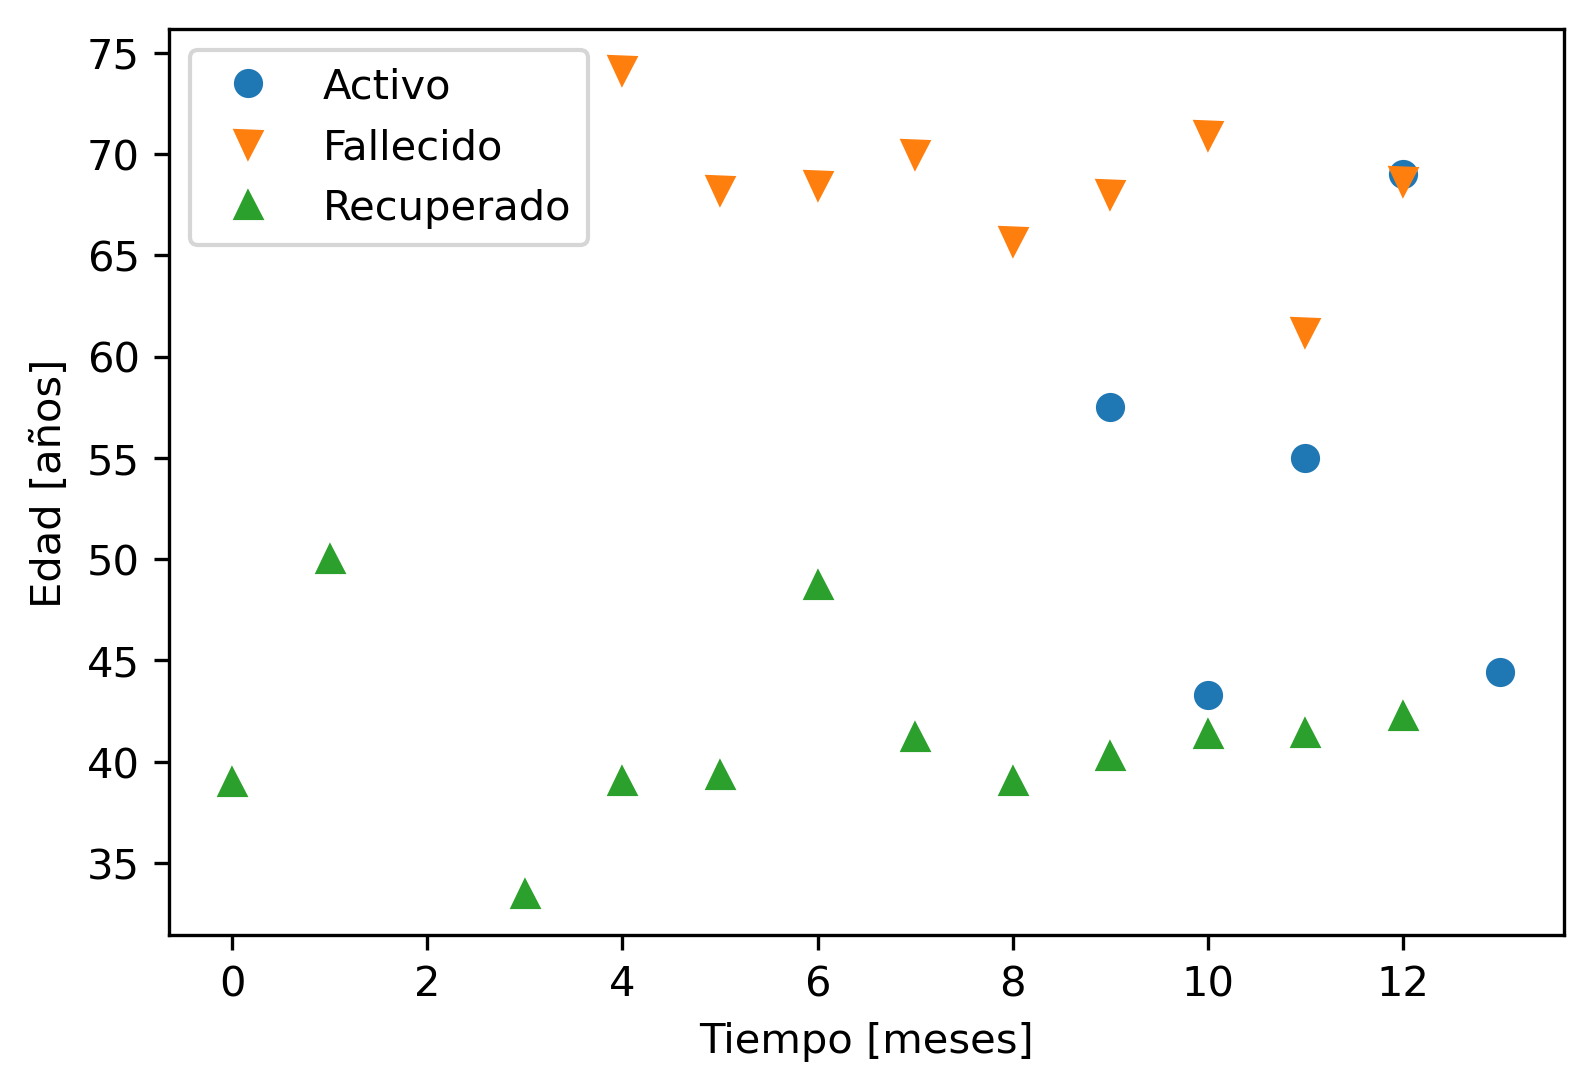

In [43]:
idx = -1
plt.figure(dpi=300)
for group, this_data in recuperado_data:
    idx += 1
    t, mean = get_means(this_data)
    plt.plot(t, mean, marks[idx], label=group)
plt.xlabel('Tiempo [meses]')
plt.ylabel('Edad [años]')
_ = plt.legend()

#### 7.4.2. Gráfica de casos por agrupamiento por *Recuperado*

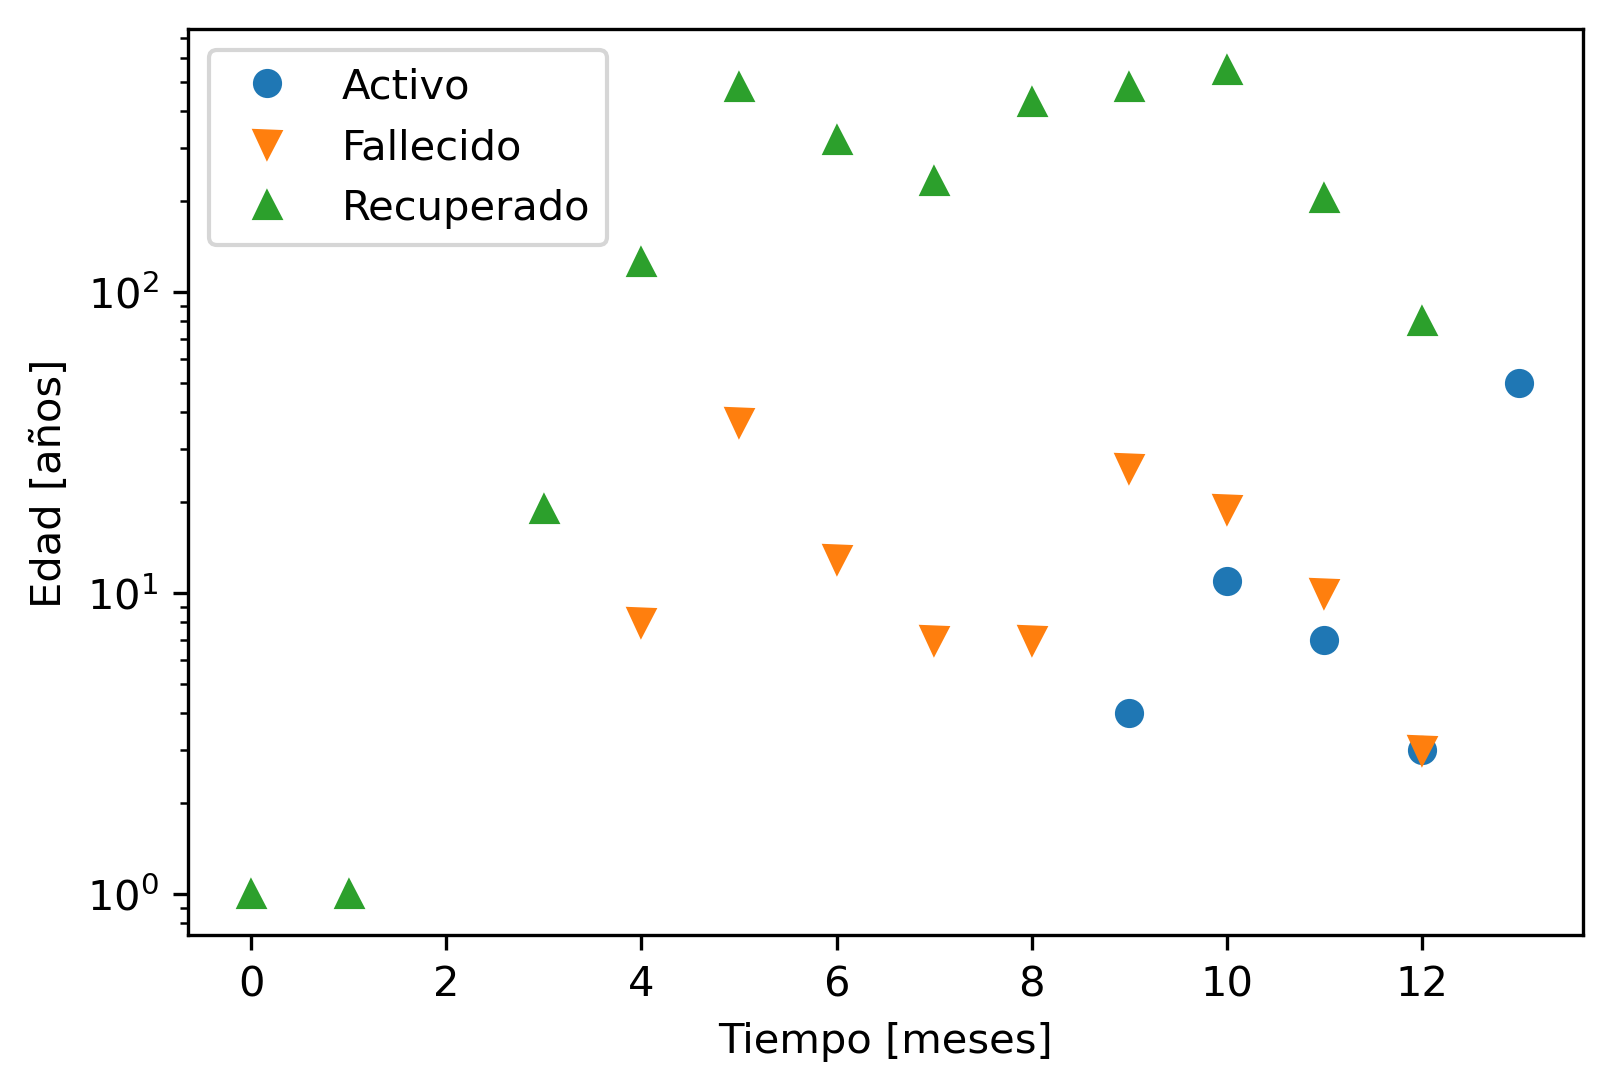

In [44]:
idx = -1
plt.figure(dpi=300)
for group, this_data in recuperado_data:
    idx += 1
    t, counts = get_counts(this_data)
    plt.semilogy(t, counts, marks[idx], label=group)
plt.xlabel('Tiempo [meses]')
plt.ylabel('Edad [años]')
_ = plt.legend()

## 8. Preguntas de autoexplicación
### 8.1. Primer conjunto de preguntas de auto explicación

8.1.1. En el ítem 1 se importan unas librerías.  Describa, de manera resumida, el propósito de cada librería importada.

8.1.2. En el ítem 2 hay dos métodos para cargar los datos, en el primero se cargan desde una carpeta local, que se crea cuando se [clona el repositorio](https://github.com/davidalejandromiranda/StatisticalPhysics.git), y en el segundo, desde un archivo en la nube.  ¿Cuál es el propósito de utilizar *try*.

8.1.3. En el ítem 3.1 se describen los datos importados, *data.describe()*, ¿de qué manera los valores de las filas *count*, *mean*, *std*, *min*, *25%*, *50%*, *75%* y *max* describen los datos de cada columna? Se sugiere comparar los ítems 3.1 y 3.4.

8.1.4. Los datos importados están organizados por columnas, ¿qué información contienen dichas columnas?

8.1.5. Describa cómo se analizan los datos de las columnas *Recuperado* y *Edad*.  Tenga en cuenta que antes de procesar los datos estos son limpiados y luego se realiza el análisis.

### 8.2. Segundo conjunto de preguntas de auto explicación

8.2.1. Interprete cada una de las pruebas de normalidad aplicadas en el ítem 6.  Se sugiere acompañar la interpretación con los gráficos de violín (ítem 5.2) y los *boxplot* (ítem 5.3) obtenidos.

8.2.2. Describa cómo se realiza la limplieza de datos para el análisis temporal, ítem 7.1.

8.2.3. En la línea 3 del ítem 7.2 se utiliza el comando *d.days*, ¿cuál es el propósito de utilizar dicho comando?

8.2.4. ¿Cuál es el propósito de ralizar un submuestreo de los datos y cómo se realiza?

8.2.5. En el ítem 7.4 se analizan los valores medios de datos muestreados para cada 30 días.  Interprete el análisis temporal de *Edad* teniendo en cuenta el agrupamiento por la columna *Recuperado*.





### 8.3. Tercer conjunto de preguntas de autoexplicación

8.3.1. ¿Es posible obtener una variable aleatoria normal para describir la *Edad*?  Si su respuesta es afirmativa, muestre cómo se hace y cuáles son las limitaciones de realizar ese procesamiento a los datos.

8.3.2. ¿Cuál es la edad media de casos Activos, Fallecidos y Recuperados en los municipios del Área Metropolitana de Bucaramanga?

8.3.3. ¿Cuál ha sido el comportamiento en el tiempo de la edad para los casos Activos, Fallecidos y Recuperados en los municipios del Área Metropolitana de Bucaramanga?

8.3.4. En los datos importados hay más información de la analizada en este ejemplo.  Presente su propio análisis complementario.

8.3.5. Describa, con sus propias palabras, qué aprendió al resolver las preguntas de autoexplicación de este Jupyter Notebook.

End!